In [1]:
import torch
import math
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import os
import matplotlib.pyplot as plt

class BEVCamera:
    def __init__(self, x_range=(-50, 50), y_range=(-50, 50), image_size=200):
        # Orthographic projection parameters
        self.x_min, self.x_max = x_range
        self.y_min, self.y_max = y_range
        self.image_width = image_size
        self.image_height = image_size

        # Set up FoV to cover the range [-50, 50] for both X and Y
        self.FoVx = (self.x_max - self.x_min)  # Width of the scene in world coordinates
        self.FoVy = (self.y_max - self.y_min)  # Height of the scene in world coordinates

        # Camera position: placed above the scene, looking down along Z-axis
        self.camera_center = torch.tensor([0, 0, 200], dtype=torch.float32).to('cuda:0')  # High above Z-axis
        
        # View matrix: Identity matrix (no rotation, just top-down view)
        self.world_view_transform = torch.tensor([
            [ 0.,  2.,  0.,         0.],
            [ 2.,  0.,  0.,         0.],
            [ 0.,  0.,  0.,         0.],
            [ 0.,  0.,  0.,         0.],
        ], dtype=torch.float32).to('cuda:0')

        # Orthographic projection matrix for BEV
        self.full_proj_transform = self.orthographic_projection().to('cuda:0')
    
    def orthographic_projection(self):
        """ Set up an orthographic projection matrix for BEV. """
        # Create an orthographic projection matrix
        proj_matrix = torch.tensor([
            [ 0., -2.,  0.,         100.],
            [-2,   0.,  0.,         100.],
            [ 0.,  0.,  0.,           1.],
            [ 0.,  0.,  0.,           1.],
        ], dtype=torch.float32)
        return proj_matrix

# Instantiate the camera
bev_camera = BEVCamera()

In [2]:
def strip_lowerdiag(L):
    uncertainty = torch.zeros((L.shape[0], 6), dtype=torch.float, device="cuda")

    uncertainty[:, 0] = L[:, 0, 0]
    uncertainty[:, 1] = L[:, 0, 1]
    uncertainty[:, 2] = L[:, 0, 2]
    uncertainty[:, 3] = L[:, 1, 1]
    uncertainty[:, 4] = L[:, 1, 2]
    uncertainty[:, 5] = L[:, 2, 2]
    return uncertainty

def quaternion_to_rotation_matrix_batch(quaternions):
    """
    Converts a batch of quaternions to a batch of 3x3 rotation matrices.
    quaternions: Tensor of shape (b, G, 4) representing the quaternion (q_w, q_x, q_y, q_z)
    
    Output: Tensor of shape (b, G, 3, 3) representing the rotation matrices
    """
    q_w, q_x, q_y, q_z = torch.split(quaternions, 1, dim=-1)
    q_w = quaternions[..., 0]
    q_x = quaternions[..., 1]
    q_y = quaternions[..., 2]
    q_z = quaternions[..., 3]

    # Rotation matrix elements
    R = torch.zeros(quaternions.shape[:-1] + (3, 3), device=quaternions.device)
    
    R[..., 0, 0] = 1 - 2 * (q_y ** 2 + q_z ** 2)
    R[..., 0, 1] = 2 * (q_x * q_y - q_z * q_w)
    R[..., 0, 2] = 2 * (q_x * q_z + q_y * q_w)

    R[..., 1, 0] = 2 * (q_x * q_y + q_z * q_w)
    R[..., 1, 1] = 1 - 2 * (q_x ** 2 + q_z ** 2)
    R[..., 1, 2] = 2 * (q_y * q_z - q_x * q_w)

    R[..., 2, 0] = 2 * (q_x * q_z - q_y * q_w)
    R[..., 2, 1] = 2 * (q_y * q_z + q_x * q_w)
    R[..., 2, 2] = 1 - 2 * (q_x ** 2 + q_y ** 2)
    
    return R

def compute_covariance_matrix_batch(quaternions, scales):
    """
    Computes a batch of covariance matrices from quaternions and scales.
    quaternions: Tensor of shape (b, G, 4) representing the quaternions (q_w, q_x, q_y, q_z)
    scales: Tensor of shape (b, G, 3) representing the scale (variance) along x, y, z axes
    
    Output: Tensor of shape (b, G, 3, 3) representing the covariance matrices
    """
    # Convert quaternion to a batch of rotation matrices
    R = quaternion_to_rotation_matrix_batch(quaternions)
    
    # Create a diagonal scale matrix for each Gaussian
    S = torch.zeros(scales.shape[:-1] + (3, 3), device=scales.device)
    S[..., 0, 0] = scales[..., 0]  # Scale for x
    S[..., 1, 1] = scales[..., 1]  # Scale for y
    S[..., 2, 2] = scales[..., 2]  # Scale for z

    # Compute the covariance matrix: R * S * R^T
    # Use batch matrix multiplication: bmm for batched matrices
    L = R @ S 
    covariance_matrices = L @ L.transpose(-1, -2) # R S ST RT
    return covariance_matrices

def generate_random_gaussians(num_gaussians, scaling_modifier=1.0):
    # means3D = torch.rand((num_points, 3), dtype=torch.float32, device="cuda") * 100 - 50  # Random points in [-50, 50]
    # means2D = screenspace_points
    # opacity = torch.rand((num_points,), dtype=torch.float32, device="cuda")  # Random opacity

    # # Random scaling and rotation
    # scales = torch.rand((num_points,), dtype=torch.float32, device="cuda") * scaling_modifier  # Random scales
    # rotations = torch.eye(3, dtype=torch.float32, device="cuda").unsqueeze(0).repeat(num_points, 1, 1)  # Identity rotation

    # Generate random 3D means (positions) for the Gaussians
    means3D = torch.rand((num_gaussians, 3), dtype=torch.float32, device='cuda') * 100 - 50  # Random positions in a 10x10x10 box
    means3D = torch.tensor([[0.0, 0.0, -2.0], [0.0,0.0,0.0]]).to('cuda:0')
    # print(means3D)
    # Generate random screen-space 2D points (this is just to mock up the input, will be recalculated)
    means2D = torch.zeros((num_gaussians, 2), dtype=torch.float32, requires_grad=True)

    # Generate random opacities between 0 and 1
    opacities = torch.rand((num_gaussians,), dtype=torch.float32, device='cuda')
    opacities = torch.ones((num_gaussians,), dtype=torch.float32, device='cuda')

    # Generate random scaling (covariance) and rotation for the Gaussians
    scales = torch.rand((num_gaussians, 3), dtype=torch.float32, device='cuda') * scaling_modifier  # Random scale for each Gaussian
    # scales = torch.ones((num_gaussians,), dtype=torch.float32, device='cuda')
    scales = torch.tensor([[1., 0., 0.0], [1., 0., 0.0]]).to('cuda:0')

    rotations = torch.rand((num_gaussians, 4), dtype=torch.float32, device='cuda')
    rotations = torch.tensor([[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0]]).to('cuda:0')
    rotations = torch.nn.functional.normalize(rotations, dim=-1)
    covariance = compute_covariance_matrix_batch(rotations, scales)
    # print(covariance)
    covariance = strip_lowerdiag(covariance)
    print("covariance:", covariance)
    # Generate random SH (Spherical Harmonics) features or precomputed colors
    colors_precomp = torch.ones((num_gaussians, 128), dtype=torch.float32, device='cuda')  # Random RGB colors
    
    return means3D, means2D, opacities, scales, rotations, colors_precomp, covariance

def render_random_gaussians(viewpoint_camera, bg_color: torch.Tensor, num_gaussians=100, scaling_modifier=1.0):
    """
    Render a scene with random Gaussians.
    
    Background tensor (bg_color) must be on GPU!
    """
    # Set up rasterization configuration
    tanfovx = math.tan(viewpoint_camera.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_camera.FoVy * 0.5)

    raster_settings = GaussianRasterizationSettings(
        image_height=int(viewpoint_camera.image_height),
        image_width=int(viewpoint_camera.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_camera.world_view_transform,
        projmatrix=viewpoint_camera.full_proj_transform,
        sh_degree=0,  # No SHs used for random Gaussians
        campos=viewpoint_camera.camera_center,
        prefiltered=False,
        debug=False
    )

    rasterizer = GaussianRasterizer()
    rasterizer.set_raster_settings(raster_settings)

    # Generate random Gaussians' parameters
    means3D, means2D, opacities, scales, rotations, colors_precomp, covariance = generate_random_gaussians(num_gaussians, scaling_modifier)
    # Rasterize visible Gaussians to image, obtain their radii (on screen). 
    rendered_image, radii = rasterizer(
        means3D=means3D,
        means2D=None,
        shs=None,  # No SHs used
        colors_precomp=colors_precomp,
        opacities=opacities,
        scales=None,
        rotations=None,
        cov3D_precomp=covariance)

    return {
        "render": rendered_image,
        "viewspace_points": means2D,
        "visibility_filter": radii > 0,
        "radii": radii,
        "markVisible": rasterizer.markVisible(means3D)
    }


In [3]:
# Example random bg_color tensor (black background)
bg_color = torch.zeros((128), dtype=torch.float32, device="cuda")

# Example BEV Camera definition from previous code
bev_camera = BEVCamera()

# Call the modified render function
output = render_random_gaussians(bev_camera, bg_color, num_gaussians=2)

covariance: tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]], device='cuda:0')


tensor([True, True], device='cuda:0')
tensor([True, True], device='cuda:0')


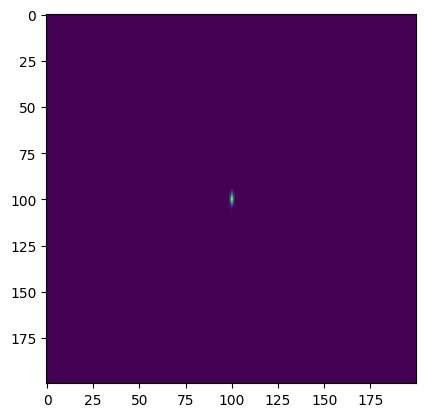

In [4]:
# print(output['render'][:1])
print(output['visibility_filter'])
print(output['markVisible'])
render = output['render'][:1].detach().permute(1,2,0).cpu().numpy()
# render[::4, ::4] = 1
plt.imshow(render)

In [5]:
output['render'][0, 86:101, 100]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0304,
        0.1093, 0.3112, 0.7023, 1.2561, 1.7805, 2.0000], device='cuda:0')